## CIFAR10 데이터셋을 가지고 연습해봅시다

### DataLoading

In [1]:
%matplotlib inline

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [4]:
n_classes = len(classes)
x, w, h, c = trainloader.dataset.data.shape

In [5]:
from matplotlib import pyplot as plt
import numpy as np

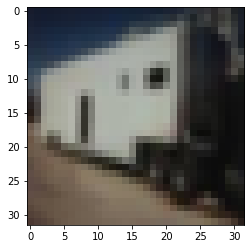

In [6]:
img = trainset.data[1201]
plt.imshow(img)

In [7]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
import torch.nn.functional as F

## model

In [8]:
class CIFAR_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        # nn.Conv2d(in_channels, out_channels)
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1) # RGB channel 개수가 1->3 이어서 변경해줌
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(16, n_classes, kernel_size=3, stride=2, padding=1)
    
    def forward(self, xb):
        xb = xb.view(-1, c, w, h) # [1000, 32, 32, 3] -> [1000, 3, 32, 32]
        xb = F.relu(self.conv1(xb)) # [1000, 3, 32, 32] -> [1000, 16, 16, 16]
        xb = F.relu(self.conv2(xb)) # [1000, 16, 16, 16] -> [1000, 16, 8, 8]
        xb = F.relu(self.conv3(xb)) # [1000, 16, 8, 8] -> [1000, 10, 4, 4] 
        xb = F.avg_pool2d(xb, 4) # [1000, 10, 4, 4] -> [1000, 10, 1, 1]
        return xb.view(-1, xb.size(1))

In [9]:
lr = 0.05
model = CIFAR_CNN()
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.CrossEntropyLoss()

## Tensorboard 

In [10]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/cifar')

In [11]:
# 이미지를 보여주기 위한 헬퍼(helper) 함수
# (아래 `plot_classes_preds` 함수에서 사용)
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

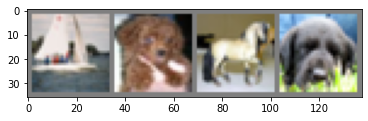

In [12]:
dataiter = iter(trainloader)
images, labels = dataiter.next()
img_grid = torchvision.utils.make_grid(images)
matplotlib_imshow(img_grid)

### image 추가 하기

In [13]:
writer.add_image('four_cifar_object', img_grid)

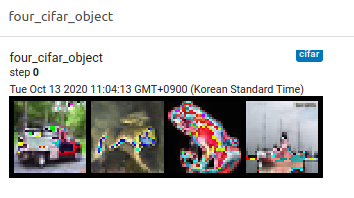

### model graph 추가 하기 

In [14]:
writer.add_graph(model, images)
writer.close()

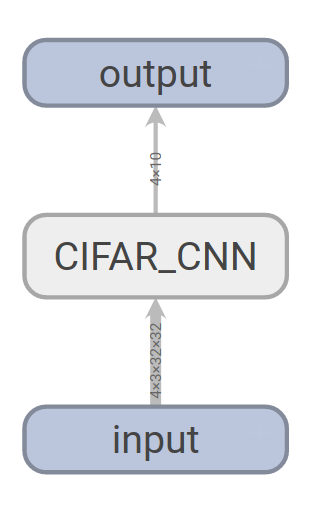

In [15]:
import random

### embedding(projector) 추가 하기

In [37]:
random_index = random.sample(range(0, len(testset.data)), 100)
images, labels = torch.tensor(trainset.data[random_index]), np.array(trainset.targets)[random_index]
class_labels = [classes[label] for label in labels]
features = images.reshape(-1, w * h * c)
images = images.reshape(100, c, w, h)
writer.add_embedding(features,
                    metadata=class_labels,
                    label_img=images,
                    global_step='cifar10') # 이미 embedding 그래프를 그린적이 있어서 이름 지정
writer.close()

아무것도 안나옴..ㅠㅠ 

### learning curve 추가 하기 

In [24]:
labels

array([2, 1, 8, 3, 0, 0, 4, 4, 8, 2, 7, 1, 4, 7, 2, 1, 4, 0, 4, 2, 0, 3,
       4, 9, 5, 1, 8, 7, 3, 0, 3, 3, 4, 8, 2, 0, 9, 5, 2, 2, 7, 2, 9, 3,
       3, 7, 6, 5, 4, 9, 2, 9, 9, 2, 8, 0, 4, 2, 7, 0, 3, 0, 8, 2, 8, 8,
       6, 4, 2, 7, 8, 7, 3, 8, 7, 9, 5, 5, 5, 5, 8, 5, 5, 6, 4, 8, 4, 7,
       6, 9, 0, 9, 8, 6, 7, 0, 4, 5, 8, 0])

In [18]:
def images_to_probs(net, images):
    '''
    학습된 신경망과 이미지 목록으로부터 예측 결과 및 확률을 생성합니다
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.numpy())
    return preds, [F.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    학습된 신경망과 배치로부터 가져온 이미지 / 라벨을 사용하여 matplotlib
    Figure를 생성합니다. 이는 신경망의 예측 결과 / 확률과 함께 정답을 보여주며,
    예측 결과가 맞았는지 여부에 따라 색을 다르게 표시합니다. "images_to_probs"
    함수를 사용합니다.
    '''
    preds, probs = images_to_probs(net, images)
    # 배치에서 이미지를 가져와 예측 결과 / 정답과 함께 표시(plot)합니다
    fig = plt.figure(figsize=(12, 48))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matplotlib_imshow(images[idx], one_channel=True)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

In [27]:
running_loss = 0.0
for epoch in range(1):  # 데이터셋을 여러번 반복

    for i, data in enumerate(trainloader, 0):

        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 1000 == 999:    # 매 1000 미니배치마다...
            print('[Epoch {}] loss : {}'.format(epoch, running_loss))
            # ...학습 중 손실(running loss)을 기록하고
            writer.add_scalar('training loss',
                            running_loss / 1000,
                            epoch * len(trainloader) + i)

            # ...무작위 미니배치(mini-batch)에 대한 모델의 예측 결과를 보여주도록
            # Matplotlib Figure를 기록합니다
            writer.add_figure('predictions vs. actuals',
                            plot_classes_preds(model, inputs, labels),
                            global_step=epoch * len(trainloader) + i)
            running_loss = 0.0
print('Finished Training')

[Epoch 0] loss : 2012.3404272794724
[Epoch 0] loss : 1998.393703341484
[Epoch 0] loss : 1979.7061257362366
[Epoch 0] loss : 1966.4295566678047
[Epoch 0] loss : 1964.052260518074
[Epoch 0] loss : 1958.3207607865334
[Epoch 0] loss : 1964.0654366612434
[Epoch 0] loss : 1968.41790497303
[Epoch 0] loss : 1985.0175493955612
[Epoch 0] loss : 1972.5678411126137
[Epoch 0] loss : 1951.3772685527802
[Epoch 0] loss : 1955.1011445522308
Finished Training


In [21]:
# 1. 예측 확률을 test_size x num_classes 텐서로 가져옵니다
# 2. 예측 결과를 test_size 텐서로 가져옵니다
# 실행하는데 10초 이하 소요
class_probs = []
class_preds = []
with torch.no_grad():
    for data in testloader:
        images, labels = data
        output = model(images)
        class_probs_batch = [F.softmax(el, dim=0) for el in output]
        _, class_preds_batch = torch.max(output, 1)

        class_probs.append(class_probs_batch)
        class_preds.append(class_preds_batch)

test_probs = torch.cat([torch.stack(batch) for batch in class_probs])
test_preds = torch.cat(class_preds)

# 헬퍼 함수
def add_pr_curve_tensorboard(class_index, test_probs, test_preds, global_step=0):
    '''
    0부터 9까지의 "class_index"를 가져온 후 해당 정밀도-재현율(precision-recall)
    곡선을 그립니다
    '''
    tensorboard_preds = test_preds == class_index
    tensorboard_probs = test_probs[:, class_index]

    writer.add_pr_curve(classes[class_index],
                        tensorboard_preds,
                        tensorboard_probs,
                        global_step=global_step)
    writer.close()

# 모든 정밀도-재현율(precision-recall; pr) 곡선을 그립니다
for i in range(len(classes)):
    add_pr_curve_tensorboard(i, test_probs, test_preds)

아무 것도 안나옴..ㅠㅜ 